<a href="https://colab.research.google.com/github/rthomps5/SC-QAM-Nonlinear-Distortion-Modeling/blob/main/Binary_Classification_of_Nonlinear_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

QAM Constellation data viewing will require both numpy and pyplot

In [19]:
import numpy as np
import matplotlib as mat
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd

print("numpy ver", np.__version__)  # should be 1.21.5+
print("matplotlib ver", mat.__version__)  # should be 3.2.2+
print("tensorflow ver", tf.__version__)  # should be 2.8.0+
print("pandas ver", pd.__version__)  # should be 1.3.5+

numpy ver 1.21.5
matplotlib ver 3.2.2
tensorflow ver 2.8.0
pandas ver 1.3.5


Floating point precision to 3 decimal places

In [20]:
np.set_printoptions(suppress=True, precision=3, formatter={'float': '{: 0.3f}'.format})

Symbol files include 1,024,000, nearly equally distributed symbols, sent in a specific sequence 

In [21]:
SYM = np.loadtxt('neg50dBc64QAMSYMv2.txt')

Varying nonlinear distortion recorded for the same symbol sequence

In [22]:
IQ = np.loadtxt('neg26dBc64QAMIQv2.txt')

Must to set "qpss" equal to the constellation size of the data, (QPSK, 16-QAM, or 64-QAM) and then comment out the remaining two

In [23]:
#QPSK Ideal
#qpss = np.array([1+1j, -1+1j, 1-1j, -1-1j]/np.sqrt(2))
#16-QAM Ideal
#qpss = np.array([3+3j, 1+3j, -1+3j, -3+3j, 3+1j, 1+1j, -1+1j, -3+1j, 
#                     3-1j, 1-1j, -1-1j, -3-1j, 3-3j, 1-3j, -1-3j, -3-3j]/np.sqrt(18))
#64-QAM Ideal
qpss = np.array([7+7j, 5+7j, 3+7j, 1+7j, -1+7j, -3+7j, -5+7j, -7+7j,
        7+5j, 5+5j, 3+5j, 1+5j, -1+5j, -3+5j, -5+5j, -7+5j,
        7+3j, 5+3j, 3+3j, 1+3j, -1+3j, -3+3j, -5+3j, -7+3j,
        7+1j, 5+1j, 3+1j, 1+1j, -1+1j, -3+1j, -5+1j, -7+1j,
        7-1j, 5-1j, 3-1j, 1-1j, -1-1j, -3-1j, -5-1j, -7-1j,
        7-3j, 5-3j, 3-3j, 1-3j, -1-3j, -3-3j, -5-3j, -7-3j,
        7-5j, 5-5j, 3-5j, 1-5j, -1-5j, -3-5j, -5-5j, -7-5j,
        7-7j, 5-7j, 3-7j, 1-7j, -1-7j, -3-7j, -5-7j, -7-7j])/np.sqrt(98)

Create two complex data arrays for each symbol, zm = complex data point for 1,024,000 symbol sequence, qm for the corresponding ideal symbol, ~16k datapoints per 64-QAM symbol

In [24]:
N = len(SYM)
zm = np.zeros((N), dtype=complex)
qm = np.zeros((N), dtype=complex)
for i in range(N):
  zm[i] = complex(IQ[i,0],IQ[i,1])
  qm[i] = qpss[int(SYM[i])]
c='rbmgkc'

Plot ideal 64-QAM constellation

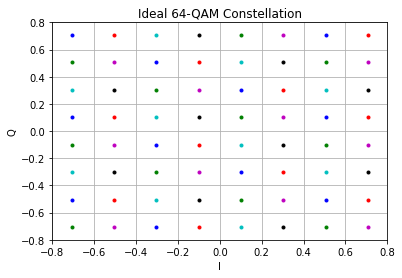

In [25]:
plt.grid()
plt.title('Ideal 64-QAM Constellation')
plt.ylabel('Q')
plt.xlabel('I')
plt.axis([-0.8, 0.8, -0.8, 0.8])
for k in range(len(qpss)):
  plt.plot(qpss[k].real, qpss[k].imag, c[np.mod(k,6)]+'.')

Plot 1,024,000 symbol constellation with severe nonlinearity

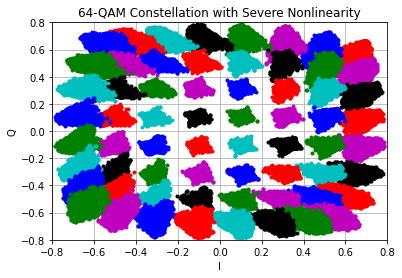

In [26]:
plt.title('64-QAM Constellation with Severe Nonlinearity')
plt.grid()
plt.ylabel('Q')
plt.xlabel('I')
plt.axis([-0.8, 0.8, -0.8, 0.8])
for k in range(len(qpss)):
  i = np.where(qm[0:N]==qpss[k])[0]
  plt.plot(zm[i].real, zm[i].imag, c[np.mod(k,6)]+'.')

Extract the 1st 500 symbols for the two overlapping classes in the upper left corner of the 64-QAM constellation, label X for complex data and y for arbitrary assignment to class 0 or 1

In [27]:
c0_sym = np.where(qm[0:N]==qpss[6])
c1_sym = np.where(qm[0:N]==qpss[7])
c0_inphase = zm[c0_sym].real[0:500]
c0_quadrature = zm[c0_sym].imag[0:500]
c1_inphase = zm[c1_sym].real[0:500]
c1_quadrature = zm[c1_sym].imag[0:500]
X_train = np.block([[c0_inphase, c1_inphase],[c0_quadrature, c1_quadrature]]).transpose()
y_train = np.append(np.zeros(500),np.ones(500)).transpose()

Interactive dataframe visualization from https://github.com/mrdbourke/tensorflow-deep-learning for interactive table to validate features and labels

In [31]:
classes = pd.DataFrame({"X0":X_train[:, 0], "X1":X_train[:, 1], "label":y_train})
classes

,X0,X1,label
0,-0.493417,0.704241,0.0
1,-0.491033,0.679921,0.0
2,-0.505764,0.635776,0.0
3,-0.507024,0.687377,0.0
4,-0.487774,0.702910,0.0
...,...,...,...
995,-0.606726,0.660368,1.0
996,-0.571033,0.667176,1.0
997,-0.575330,0.690760,1.0
998,-0.546664,0.664623,1.0


Validate equal distribution of classes

In [33]:
classes.label.value_counts()

0.0    500
1.0    500
Name: label, dtype: int64

Estimate the mean and variance from the reduced datasets

In [34]:
mean0 = np.array([c0_inphase.mean(), c0_quadrature.mean()])
var0 = c0_inphase.var()+2*np.cov(c0_inphase,c0_quadrature)[0,1]+c0_quadrature.var()
mean1 = np.array([c1_inphase.mean(), c1_quadrature.mean()])
var1 = c1_inphase.var()+2*np.cov(c1_inphase,c1_quadrature)[0,1]+c1_quadrature.var()
mean0, var0, mean1, var1

(array([-0.450,  0.681]),
 0.0009976369164965866,
 array([-0.577,  0.655]),
 0.0011784961837206015)

Visualize two upper left constellation points using a scatter plot, include the Bayes decision boundary based on Haykin text

(-0.7, -0.3, 0.55, 0.75)

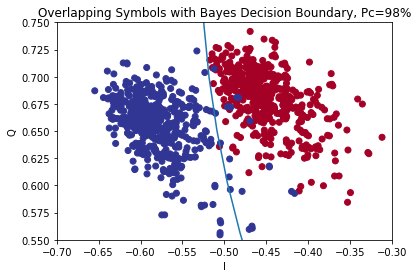

In [38]:
plt.title('Overlapping Symbols with Bayes Decision Boundary, Pc=98%')
plt.ylabel('Q')
plt.xlabel('I')
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=plt.cm.RdYlBu)

# Calculated Bayes decision boundary based on Haykin
Bayes = np.loadtxt('Bayes Decision Boundary Data_v6.txt')
plt.plot(Bayes[:,0],Bayes[:,1])
plt.axis([-0.7, -0.3, 0.55, 0.75])

For Neural Network Binary Classification, check the shapes of features and labels

In [39]:
X_train.shape, y_train.shape

((1000, 2), (1000,))

Confirm samples 

In [40]:
len(X_train), len(y_train)

(1000, 1000)

View the first example of features and labels

In [41]:
X_train[0], y_train[0]

(array([-0.493,  0.704]), 0.0)

Decision boundary visualization from https://github.com/mrdbourke/tensorflow-deep-learning

In [42]:
def plot_decision_boundary(model, X, y):
  """
  Plots the decision boundary created by a model predicting on X.
  This function has been adapted from two phenomenal resources:
   1. CS231n - https://cs231n.github.io/neural-networks-case-study/
   2. Made with ML basics - https://github.com/GokuMohandas/MadeWithML/blob/main/notebooks/08_Neural_Networks.ipynb
  """
  # Define the axis boundaries of the plot and create a meshgrid
  x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
  y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
  xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                       np.linspace(y_min, y_max, 100))
  
  # Create X values (we're going to predict on all of these)
  x_in = np.c_[xx.ravel(), yy.ravel()] # stack 2D arrays together: https://numpy.org/devdocs/reference/generated/numpy.c_.html
  
  # Make predictions using the trained model
  y_pred = model.predict(x_in)

  # Check for multi-class
  if len(y_pred[0]) > 1:
    print("doing multiclass classification...")
    # We have to reshape our predictions to get them ready for plotting
    y_pred = np.argmax(y_pred, axis=1).reshape(xx.shape)
  else:
    print("doing binary classifcation...")
    y_pred = np.round(y_pred).reshape(xx.shape)
  
  # Plot decision boundary
  plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
  plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
  plt.xlim(xx.min(), xx.max())
  plt.ylim(yy.min(), yy.max())

NN to model adapted from https://github.com/mrdbourke/tensorflow-deep-learning and https://playground.tensorflow.org/ to classify the two datasets

In [45]:
# Set random seed
tf.random.set_seed(42)

# Create a model
model = tf.keras.Sequential([
  tf.keras.layers.Dense(8, activation=tf.keras.activations.tanh), # hidden layer 1, ReLU activation
  tf.keras.layers.Dense(8, activation=tf.keras.activations.tanh), # hidden layer 2, ReLU activation
  tf.keras.layers.Dense(8, activation=tf.keras.activations.tanh), # hidden layer 3, ReLU activation
  tf.keras.layers.Dense(8, activation=tf.keras.activations.tanh), # hidden layer 4, ReLU activation
  tf.keras.layers.Dense(1, activation=tf.keras.activations.sigmoid) # ouput layer, sigmoid activation
])

# Compile the model
model.compile(loss=tf.keras.losses.binary_crossentropy,
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

# Fit the model
history = model.fit(X_train, y_train, epochs=100, verbose=0)

Summarize model

In [46]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 8)                 24        
                                                                 
 dense_11 (Dense)            (None, 8)                 72        
                                                                 
 dense_12 (Dense)            (None, 8)                 72        
                                                                 
 dense_13 (Dense)            (None, 8)                 72        
                                                                 
 dense_14 (Dense)            (None, 1)                 9         
                                                                 
Total params: 249
Trainable params: 249
Non-trainable params: 0
_________________________________________________________________


Evaluate model

In [47]:
model.evaluate(X_train, y_train)

32/32 [==============================] - 0s 1ms/step - loss: 0.0548 - accuracy: 0.9820


[0.05479113757610321, 0.9819999933242798]

Get the next 500 datapoints for test data

In [48]:
c0_inphase = zm[c0_sym].real[500:1000]
c0_quadrature = zm[c0_sym].imag[500:1000]
c1_inphase = zm[c1_sym].real[500:1000]
c1_quadrature = zm[c1_sym].imag[500:1000]
X_test = np.block([[c0_inphase, c1_inphase],[c0_quadrature, c1_quadrature]]).transpose()
y_test = np.append(np.zeros(500),np.ones(500)).transpose()

Check the shapes of the test data

In [49]:
X_train.shape, X_test.shape

((1000, 2), (1000, 2))

Evaluate model on the test set

In [50]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Model loss on the test set: {loss}")
print(f"Model accuracy on the test set: {100*accuracy:.2f}%")

32/32 [==============================] - 0s 1ms/step - loss: 0.0394 - accuracy: 0.9870
Model loss on the test set: 0.03943498060107231
Model accuracy on the test set: 98.70%


View the predictions of the model with relu and sigmoid activations

doing binary classifcation...
doing binary classifcation...


(-0.7, -0.3, 0.55, 0.75)

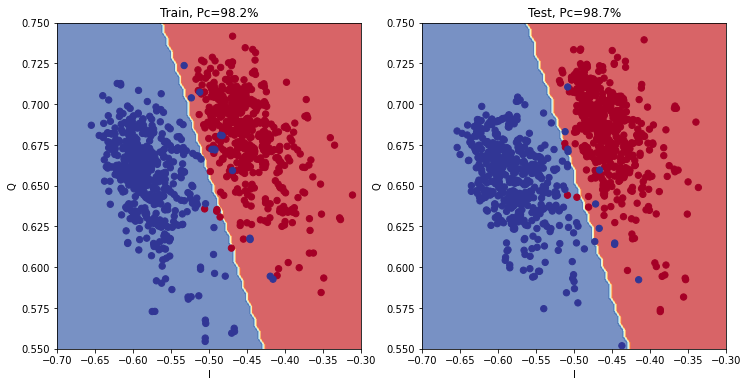

In [51]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train, Pc=98.2%")
plt.ylabel('Q')
plt.xlabel('I')
plot_decision_boundary(model, X=X_train, y=y_train)
plt.axis([-0.7, -0.3, 0.55, 0.75])
plt.subplot(1, 2, 2)
plt.title("Test, Pc=98.7%")
plt.ylabel('Q')
plt.xlabel('I')
plot_decision_boundary(model, X=X_test, y=y_test)
plt.axis([-0.7, -0.3, 0.55, 0.75])

Display the information in the history variable using the .history attribute

In [52]:
pd.DataFrame(history.history)

,loss,accuracy
0,0.686710,0.503
1,0.663070,0.828
2,0.630879,0.981
3,0.562368,0.977
4,0.446900,0.980
...,...,...
95,0.055176,0.983
96,0.055041,0.981
97,0.056403,0.980
98,0.055961,0.982


Plot the loss and accuracy curves

Text(0.5, 1.0, 'Model training curves')

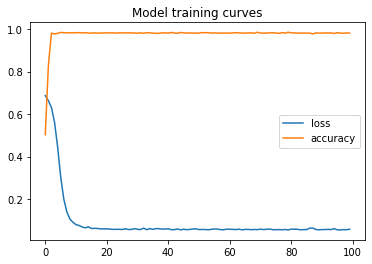

In [53]:
pd.DataFrame(history.history).plot()
plt.title("Model training curves")